# Importaciones

In [3]:
# Sistema
import os
import copy
import time
# Gráficas
import matplotlib.pyplot as plt
# Matemática y estructura
import numpy as np
import pandas as pd
# Logging
import logging
# Inteligencia artificial
import torch
# Imágenes
from PIL import Image
# (Torch)
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision import tv_tensors
# Aumento de datos
from torchvision.transforms import v2
# Dataset
from collections import defaultdict
# Modelo
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights
from torchvision.models.mobilenetv3 import mobilenet_v3_large
# Capas
import torch.nn as nn
# Entrenamiento
import torch.optim as optim
# Métricas
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score

# Ajuste Logging

In [4]:
logger = logging.getLogger(__name__)  # Logger específico del módulo
logger.setLevel(logging.INFO)  # INFO o DEBUG

# Solo si no hay handlers configurados aún (evita duplicados)
if not logger.hasHandlers():
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

In [5]:
# Activa o desactiva logs fácilmente
ENABLE_LOGS = True

# Aumento de datos

## Creación del Pipeline (Personalizado)

In [6]:
# Constantes de transformaciones aceptadas por MobileNet
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
_resize = 256
_crop = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

In [7]:
# Pipeline
transform_augmented = v2.Compose([
    # Transformaciones de aumento de datos \
    v2.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.RandomVerticalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.RandomRotation(degrees=15),  # Rotación aleatoria en un rango de ±15 grados (POSIBLEMENTE QUITAR, CREO AGREGA RUIDO)
    v2.ColorJitter(brightness=0.2, contrast=0.1), # Ajuste aleatorio de brillo y contraste en +-0.2
    v2.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 0.9)), # Desenfoque Gaussiano aleatorio
    # Transformaciones requeridas
    v2.Resize(_resize, interpolation=v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(_crop),
    # Conversiones y normalizaciones
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=_mean, std=_std),
])

# Dataset

## Carga de dataset desde Jupyter Lab

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# path = "Dataset"
path = "/home/daniel/Documentos/Universidad/TIC/Dataset_Hugging"
# path = "/content/drive/MyDrive/Universidad/Ciclo_8/PIC/Dataset/Dataset - Hugging"
metadata_file = 'metadata.csv'
df_hugging = pd.read_csv(os.path.join(path, metadata_file), sep=',') # Path image
df_hugging = df_hugging.rename(columns={"file_name": "image"})
df_hugging['image'] = df_hugging['image'].apply(lambda x: os.path.join(path, x))
df_hugging.head(5)

,image,label
0,/home/daniel/Documentos/Universidad/TIC/Datase...,Faique
1,/home/daniel/Documentos/Universidad/TIC/Datase...,Faique
2,/home/daniel/Documentos/Universidad/TIC/Datase...,Faique
3,/home/daniel/Documentos/Universidad/TIC/Datase...,Faique
4,/home/daniel/Documentos/Universidad/TIC/Datase...,Faique


In [10]:
def extraer_especimen_id(filename):
    """
    Extrae el ID del espécimen del nombre del archivo.
    Formato: BM01_0001.jpg -> BM01
            CM05_0023.jpg -> CM05
    """
    basename = os.path.basename(filename)
    # Remover extensión
    name_without_ext = basename.split('.')[0]
    # Extraer los primeros caracteres antes del segundo '_'
    # Ejemplo: BM01_0001 -> BM01
    parts = name_without_ext.split('_')
    if len(parts) >= 2:
        # Retorna especie + número de espécimen (ej: BM01)
        return parts[0]
    return name_without_ext

In [11]:
# Crear columna de espécimen ID (ej: BM01, CM05, etc.)
df_hugging['especimen_id'] = df_hugging['image'].apply(extraer_especimen_id)

# Extraer código de especie (primeras 2 letras: BM, CM, JN, HC)
df_hugging['species'] = df_hugging['especimen_id'].str[:2]

df_hugging['group_id'] = df_hugging['especimen_id']

print("\nEjemplo de grupos creados:")
print(df_hugging[['image', 'especimen_id', 'species', 'group_id']].head(10))


Ejemplo de grupos creados:
                                               image especimen_id species  \
0  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
1  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
2  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
3  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
4  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
5  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
6  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
7  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
8  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   
9  /home/daniel/Documentos/Universidad/TIC/Datase...         BM01      BM   

  group_id  
0     BM01  
1     BM01  
2     BM01  
3     BM01  
4     BM01  
5     BM01  
6     BM01  
7     BM01  
8     B

## Construir Dataset con Dataset (Torch)

In [12]:
# Clase para la construcción del dataset
class WoodDataset(torch.utils.data.Dataset):
    """
    Dataset personalizado para la clasificación de especies de madera:
    Código -> Especie
    CM -> cedro
    BM -> faique
    JN -> nogal
    HC -> guayacan

    Este dataset usa un DataFrame de HuggingFace que contiene las imágenes y etiquetas.

    Args:
        df_hugging (pd.DataFrame): DataFrame con columnas 'image' y 'label' de HuggingFace
        transforms (callable, optional): Transformaciones a aplicar a cada imagen.
        Se envian en forma de arreglo de la siguiente forma [trans. normales, trans. para aumento de datos]

    Atributos:
        class_label (dict): Diccionario que asigna un valor numérico a cada clase.
        df (pd.DataFrame): DataFrame con las rutas de imagen y sus etiquetas.
        label_to_numeric (dict): Mapeo de etiquetas string a valores numéricos.

    Métodos:
        __getitem__(idx): Devuelve la imagen transformada y su etiqueta para el índice dado.
        __len__(): Devuelve el número total de muestras en el dataset.
    """

    def __init__(self, df_hugging, transforms=None, augmented=False):
        """
        Inicializa el dataset desde un DataFrame de HuggingFace.

        Args:
            df_hugging (pd.DataFrame): DataFrame con columnas 'image' y 'label'
            transforms (callable, optional): Transformaciones a aplicar a cada imagen.
        """
        self.df = df_hugging.copy()
        self.transforms = transforms
        self.augmented = augmented
        self.class_label = {'Cedro': 0, 'Nogal': 1, 'Faique': 2, 'Guayacán': 3}

        # Codificación de Labels
        self.df['label'] = self.df['label'].map(self.class_label)

        if ENABLE_LOGS:
            logger.info(f"Dataset inicializado con {len(self.df)} muestras")
            logger.info(f"Clases disponibles: {list(self.class_label.keys())}")


    def __getitem__(self, idx):
        """
        Devuelve la imagen transformada y su etiqueta para el índice (idx) dado.

        Args:
            idx (int): Índice de la imagen en el dataset.

        Returns:
            tuple: Una tupla que contiene la imagen transformada y su etiqueta numérica.
        """
        # Recupera el índice real independientemente del aumento de datos
        real_idx = idx % len(self.df)
        # Desempaquetado del path de la img y su label
        path_img, label, _,_, _ = self.df.iloc[real_idx]
        # Transfomación de Img a Tensor
        img = tv_tensors.Image(Image.open(path_img))

        # INICIO VALIDACIONES
        if self.transforms is None or self.transforms == []: # Comprueba si existen transformaciones disponibles
            if ENABLE_LOGS: logger.error("No hay transformaciones disponibles") # <- LOG
            return None

        if self.augmented and (idx >= len(self.df) and idx < len(self.df) * 2): # Validación de longitud en aumento
            if ENABLE_LOGS: logger.info(f"Se aplicaron las transformaciones <Aumentadas>") # <- LOG
            return self.transforms[1](img), label

        # Retro alimentación
        if ENABLE_LOGS: logger.info(f"Se aplicaron las transformaciones <Normales>") # <- LOG
        return self.transforms[0](img), label

    def __len__(self):
        """
        Devuelve el número TOTAL de TODAS las muestras en el dataset.

        Returns:
            int: Número total de muestras en el dataset.
        """
        return len(self.df) * (2 if self.augmented else 1)


    def get_class_counts(self):
        """
        Devuelve el conteo de muestras por clase.

        Returns:
            dict: Diccionario con el conteo por clase.
        """
        counts = {}
        for label_str in self.df['label'].values:
            label_numeric = self.class_label.get(label_str, 0)
            counts[label_numeric] = counts.get(label_numeric, 0) + 1
        return counts

    def get_class_names(self, inverted=False):
        """
        Devuelve los nombres de las clases.

        Args:
            inverted (bool): En caso, 'inverted' sea True, los Values y Keys cambiarán de lugar. Es decir, k:v -> v:k

        Returns:
            dict: Diccionario que mapea números a nombres de especies.
        """
        return {v:k for k,v in self.class_label.items()} if inverted else self.class_label

In [13]:
def show_image(image, label, desnormalize=True):
    """
    Desnormaliza y muestra una imagen con su etiqueta.

    Args:
        image (torch.Tensor): Imagen en formato tensor normalizado [C, H, W].
        label (str o int): Etiqueta asociada a la imagen.
    Note:
      Los valores de 'mean' y 'std' fueron extraidos de las documentación 'MobileNet_V3_Large_Weights.IMAGENET1K_V1'
      https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Desnormalizar
    image_vis = image.clone()
    if desnormalize:
        for t, m, s in zip(image_vis, mean, std):
            t.mul_(s).add_(m)

    # Recorte de valores a rango [0,1]
    # image_vis = torch.clamp(image_vis, 0, 1)
    # De tensor [C, H, W] a [H, W, C] y a NumPy
    image_vis = image_vis.permute(1, 2, 0).numpy()

    plt.imshow(image_vis)
    plt.title(f"Label: {dataset.get_class_names(inverted=True).get(label)}(lbl:{label})")
    plt.axis('off')
    plt.show()

## MobileNetV3 Large (Pesos y Transformaciones)

In [14]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
# Redimensiona a 256 con interpolación bilineal, recorta al centro a 224,
# reescala a [0.0, 1.0] y normaliza con media=[0.485, 0.456, 0.406] y desviación estándar=[0.229, 0.224, 0.225].
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
transforms = [weights.transforms(), transform_augmented]
dataset = WoodDataset(df_hugging=df_hugging, transforms=transforms, augmented = True)

INFO - Dataset inicializado con 1800 muestras
INFO - Clases disponibles: ['Cedro', 'Nogal', 'Faique', 'Guayacán']


In [15]:
len(dataset)

3600

INFO - Se aplicaron las transformaciones <Normales>


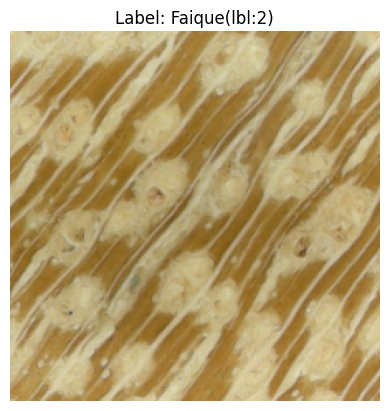

In [16]:
# Unpacking (*) => img, label = dataset[451]
show_image(*dataset[236])

## División del dataset

### Hiperpaŕametros para división

In [17]:
# Número de epocas
num_epochs = 100
# Tamaño del lote
batch_size = 32
# Semilla para reproducibilidad
seed_generator = 42

### Extracción de labels (Dataset/Train)

In [18]:

from collections import defaultdict

# IMPORTANTE: Resetear el índice del dataframe original para tener índices únicos
df_hugging = df_hugging.reset_index(drop=True)

# Agrupar especímenes por especie (con sus índices originales)
specimens_by_species = defaultdict(list)
for specimen in df_hugging['group_id'].unique():
    species = specimen[:2]  # BM, CM, JN, HC
    # Guardar los índices de todas las muestras de este espécimen
    specimen_indices = df_hugging[df_hugging['group_id'] == specimen].index.tolist()
    specimens_by_species[species].append({
        'specimen_id': specimen,
        'indices': specimen_indices
    })

# Listas de índices
train_indices = []
valid_indices = []
test_indices = []

# Seteo de la semilla
np.random.seed(seed_generator)

for species, specimen_data_list in specimens_by_species.items():
    np.random.shuffle(specimen_data_list)

    n_specimens = len(specimen_data_list)
    # Divisiones
    n_valid = max(1, int(n_specimens * 0.1))  # 10%
    n_test = max(1, int(n_specimens * 0.1))   # 10%

    # Asignar especímenes a cada conjunto
    valid_specimens = specimen_data_list[:n_valid]
    test_specimens = specimen_data_list[n_valid:n_valid+n_test]
    train_specimens = specimen_data_list[n_valid+n_test:]

    # Recolectar todos los índices de cada conjunto
    for spec in valid_specimens:
        valid_indices.extend(spec['indices'])
    for spec in test_specimens:
        test_indices.extend(spec['indices'])
    for spec in train_specimens:
        train_indices.extend(spec['indices'])

# Crear dataframes conservando los índices originales
df_train = df_hugging.loc[train_indices].copy()
df_valid = df_hugging.loc[valid_indices].copy()
df_test = df_hugging.loc[test_indices].copy()

In [19]:


# ===== 4. VERIFICACIÓN DE NO FUGA DE DATOS =====
train_specimens_set = set(df_train['group_id'].unique())
valid_specimens_set = set(df_valid['group_id'].unique())
test_specimens_set = set(df_test['group_id'].unique())

# Verificar que no hay solapamiento de especímenes
assert len(train_specimens_set & valid_specimens_set) == 0, "¡FUGA! Especímenes compartidos entre train y valid"
assert len(train_specimens_set & test_specimens_set) == 0, "¡FUGA! Especímenes compartidos entre train y test"
assert len(valid_specimens_set & test_specimens_set) == 0, "¡FUGA! Especímenes compartidos entre valid y test"

# Verificar que no hay solapamiento de índices
train_idx_set = set(df_train.index)
valid_idx_set = set(df_valid.index)
test_idx_set = set(df_test.index)

assert len(train_idx_set & valid_idx_set) == 0, "¡FUGA! Índices compartidos entre train y valid"
assert len(train_idx_set & test_idx_set) == 0, "¡FUGA! Índices compartidos entre train y test"
assert len(valid_idx_set & test_idx_set) == 0, "¡FUGA! Índices compartidos entre valid y test"

print("\n" + "="*60)
print("DIVISIÓN COMPLETADA SIN FUGA DE DATOS")
print("="*60)
print(f"Train: {len(df_train)} muestras ({len(train_specimens_set)} especímenes)")
print(f"  └─ Índices: {min(df_train.index)} a {max(df_train.index)}")
print(f"Valid: {len(df_valid)} muestras ({len(valid_specimens_set)} especímenes)")
print(f"  └─ Índices: {min(df_valid.index)} a {max(df_valid.index)}")
print(f"Test:  {len(df_test)} muestras ({len(test_specimens_set)} especímenes)")
print(f"  └─ Índices: {min(df_test.index)} a {max(df_test.index)}")

print(f"\nEspecímenes en Valid: {sorted(valid_specimens_set)}")
print(f"Especímenes en Test: {sorted(test_specimens_set)}")

# Distribución por especie en cada conjunto
print(f"\nDistribución por especie:")
print("\nTrain:")
print(df_train['species'].value_counts().sort_index())
print("\nValid:")
print(df_valid['species'].value_counts().sort_index())
print("\nTest:")
print(df_test['species'].value_counts().sort_index())


DIVISIÓN COMPLETADA SIN FUGA DE DATOS
Train: 1440 muestras (32 especímenes)
  └─ Índices: 0 a 1799
Valid: 180 muestras (4 especímenes)
  └─ Índices: 360 a 1439
Test:  180 muestras (4 especímenes)
  └─ Índices: 45 a 1709

Especímenes en Valid: ['BM09', 'CM01', 'HC02', 'JN10']
Especímenes en Test: ['BM02', 'CM02', 'HC08', 'JN03']

Distribución por especie:

Train:
species
BM    360
CM    360
HC    360
JN    360
Name: count, dtype: int64

Valid:
species
BM    45
CM    45
HC    45
JN    45
Name: count, dtype: int64

Test:
species
BM    45
CM    45
HC    45
JN    45
Name: count, dtype: int64


### Creación de Subsets

In [20]:
train_subset = Subset(dataset, df_train.index.tolist())
valid_subset = Subset(dataset, df_valid.index.tolist())
test_subset = Subset(dataset, df_test.index.tolist())

In [21]:
print(f"Train subset: {len(train_subset)} muestras") # 80 %
print(f"Valid subset: {len(valid_subset)} muestras") # 10 %
print(f"Test subset: {len(test_subset)} muestras") #  10 %
print(f"Total: {len(train_subset) + len(valid_subset) + len(test_subset)} muestras")

Train subset: 1440 muestras
Valid subset: 180 muestras
Test subset: 180 muestras
Total: 1800 muestras


### DataLoader (Test)

In [22]:
# El Loader de Train se ejecuta más adelante.
test_loader = DataLoader(test_subset, shuffle=False)

# Configuración

## Disponibilidad de CPU

In [23]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Configuración de parámetros/hiperparámetros para entrenamiento

In [24]:
def set_configuration_hiperparameters(model, learning_rate=0.001, weight_decay=0.001):
    # Criterio de perdida Entropia cruzada, eficaz para problemas de clasificación multiclase
    criterion = nn.CrossEntropyLoss()

    # Configuración del optimizador. Cada paso será de 0.001 y se acarrea el 90%
    # de la actualización anterior
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

    # Indica que el optimizador irá acercandose al mínimo global con un comportamiento de coseno. El T_max sirve como un tope en la reducción.
    # Una vez alcanzado, el optimizador comienza de nuevo. Esto puede ayudar al optimizador a encontrar valores que funcionen mejor
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    return criterion, optimizer, scheduler, learning_rate

In [25]:
def truncar(num, decimales=1):
    factor = 10**decimales
    return int(num * factor) / factor

# Codificación mecanismos de atención

## 1. Tri Attention

### 1.1 Positional Attention

In [26]:
class PositionalAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # Capas de convolució. Representación de B,C y D (según el paper)
        self.query_conv_B = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv_C = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value_conv_D = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Alfa (Ecuación 2 del paper)
        self.alpha = nn.Parameter(torch.zeros(1)) # Configura un parámetro entrenable. Tensor de dimensión 1 de ceros (valor escalar)

        # Configuración de Softmax
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Descompresión. Batch_size, Channels, Height and Width
        B,C,H,W = x.size()
        # Para el reshape (C x N, según el paper)
        N = H*W


        # Generación de tensores
        # Tensor B.
        # Conv a mapa de características (según paper)
        query_B = self.query_conv_B(x) # Retonar un tensor con la forma [B, C//8, H, W]
        # Reshape -> [B,C,N]
        query_B = query_B.view(B,-1,N) # -1 Índica una inferencia para el calculo automático de canales (hecho por Pytorch)

        # Tensor C
        # Conv a mapa de características (según paper)
        key_C = self.key_conv_C(x)
        # Reshape -> [B,C,N]
        key_C = key_C.view(B,-1,N) # -1 Índica una inferencia para el calculo automático de canales (hecho por Pytorch)

        # Tensor D
        # Conv a mapa de características (según paper)
        value_D = self.value_conv_D(x)
        # Reshape -> [B,C,N]
        value_D = value_D.view(B,-1,N) # -1 Índica una inferencia para el calculo automático de canales (hecho por Pytorch)

        # Operaciones B con C
        # Transpuesta de B y multiplicación con C
        # bmm = Batch Matrix Multiplication
        attention = torch.bmm(query_B.permute(0,2,1),key_C) # La permutación cambia de [B,C,N] a [B,N,C], para que al ser multiplicada por C[B,C,N] dé como resultado [B,N,N]
        # Aplica Softmax -> matriz S
        matrix_S = self.softmax(attention)

        # Operación con D y S
        out = torch.bmm(value_D, matrix_S.permute(0, 2, 1))
        # Reshape de [ B,N,N]-> [B,C,H,W]
        out = out.view(B,C,H,W) # Vector global de características

        # Paso final
        out = self.alpha * out + x # Fusión con alfa y el x (mapa de características de entrada, Residual Connection)

        return out

### Channel Attention

In [27]:
class ChanneAttention(nn.Module):
    def __init__(self, in_channels, reduction_radio=16):
        super().__init__()

        # Seteo de la configuración del pooling. Salida 1x1 [B,C,1,1]
        self.avg_pooling = nn.AdaptiveAvgPool2d(1)
        # Multi-layer Perceptron (MLP) con reducción de dimensionalidad
        # Primera capa que representa a W_0 ∈ R^(C/r × C)
        self.fc1 = nn.Linear(in_channels, in_channels//reduction_radio, bias=True)
        # Segunda capa que representa a W_1 ∈ R^(C × C/r)
        self.fc2 = nn.Linear(in_channels//reduction_radio, in_channels, bias=True)

        # ReLU: Función de activación entre capas
        self.relu = nn.ReLU(inplace=True)


        # Batch normalization.
        self.bn = nn.BatchNorm2d(in_channels) # in_channels siendo el número de características de la capa anterior (fc2, salida de MLP)

        # Sigmoid, para la normalización de pesos de atención
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Extracción de las dimensiones
        B,C,_,_ = x.size() # Extraemos Batch y Channel

        # Operaciones
        # Avg pooling para compresión de la información. Conseguimos F_c ∈ R^(C×1×1)
        y = self.avg_pooling(x)
        # Aplanamiento para pasar por el MLP
        y = y.view(B,C) # -> [B,C]

        # Paso por MLP
        # Primera capa, aplicamos. W0 ∈ R^(C/r×C)
        y = self.fc1(y) # [B,C/r]
        y = self.relu(y)
        # Segunda capa, aplicamos W1 ∈ R^(C×C/r)
        y = self.fc2(y) # [B,C]

        # Reshape para aplicar Batch Normalization
        y = y.view(B,C,1,1) # [B,C,1,1]

        # Aplicamos Batch Normalization
        y = self.bn(y)

        # Por último, obtenemos pesos de atención
        y = self.sigmoid(y)

        # Aplicamos la atención (elemento a elemento)
        return x * y.expand_as(x) # y intenta ser de las mismas dimensiones que el tensor x. Solo si es posible.

### Spatial Attention

In [28]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, reduction_radio=16):
        super().__init__()

        # Estructura Bottleneck
        # f0 1x1
        self.conv_1 = nn.Conv2d(in_channels,
                                in_channels//reduction_radio,
                                kernel_size=1,
                                bias=False)
        # f1 3x3 y f2 3x3
        self.conv_3 = nn.Conv2d(in_channels//reduction_radio,
                                in_channels//reduction_radio,
                                kernel_size=3,
                                padding=2,
                                dilation=2,
                                bias=False)
        # f3 1x1
        self.conv_last_1 = nn.Conv2d(in_channels//reduction_radio,
                                    1,
                                     kernel_size=1,
                                     bias=False)

        # Batch Normalización para la estabilización
        self.bn_reduction_radio =nn.BatchNorm2d(in_channels//reduction_radio)
        self.bn1 =nn.BatchNorm2d(1)

        # Función de activación ReLU
        self.relu = nn.ReLU(inplace=True)

        # Función Sigmoid para obtener los pesos ya estabilizados
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Primera convolución. Reducción de dimensionalidad. (f0 1x1)
        # De C canales a C/r
        y = self.conv_1(x) # [B,C/r,H,W]
        y = self.bn_reduction_radio(y)
        y = self.relu(y)

        # Segunda convolución. (f1 3x3)
        # Dilatación
        y = self.conv_3(y)
        y = self.bn_reduction_radio(y)
        y = self.relu(y)

        # Tercera Convolución . (f1 3x3)
        # Dilatación (Más información contextual)
        y = self.conv_3(y)
        y = self.bn_reduction_radio(y)
        y = self.relu(y)

        # Ultima convolución,
        # Genera M_s(F) ∈ R^(H×W)
        y = self.conv_last_1(y) # se obtiene [B,1,H,W] = [H,W]
        y = self.bn1(y)

        # Estandarizamos los pesos con Sigmoid
        out = self.sigmoid(y) # [B,1,H,W]

        # Aplicamos la atención espacial con la salida y la entrada
        return x * out



## Tri attention Fusion

In [29]:
class TriAttention(nn.Module):
    """
    Clase que implementa las tres clases anteriores [PositionalAttention, ChannelAttention, y SpatialAttention]
    """
    def __init__(self, in_channels, reduction_radio=16):
        super().__init__()

        # INICIALIZACION - Ramas de anteción
        # Inicialización de la Attention posicional
        self.positional_attention = PositionalAttention(in_channels=in_channels)
        # Inicialización de la Attention por canal
        self.channel_attention = ChanneAttention(in_channels=in_channels,reduction_radio=reduction_radio)
        # Inicialización de la Attention spacial
        self.spatial_attention = SpatialAttention(in_channels=in_channels,reduction_radio=reduction_radio)


        # FUSIÓN DE LOS TRES MECANISMOS
        # Capa de convolución para juntar los tres canales y que recupere los canales originales
        self.fusion_conv = nn.Conv2d(in_channels*3, in_channels, kernel_size=1)
        # Capa para Batch Normalizarion
        self.bn = nn.BatchNorm2d(in_channels)
        # Función de activación ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x : [B,C,H,W]

        # Aplicamos al mapa de características los ramas de atención de forma independiente
        # Salida de la rama de atención Posicional
        positional_out = self.positional_attention(x)
        # Salida de la rama de atención Espacial
        spatial_out = self.spatial_attention(x)
        # Salida de la rama de atención de Canal
        channel_out = self.channel_attention(x)

        # Concatenamos las tres salidas
        out_concat = torch.cat([positional_out, spatial_out, channel_out], dim=1) # [B,3C,H,W]

        # Fusionamos en un solo vector
        fused = self.fusion_conv(out_concat) # [B,3C,H,W] -> [B,C,H,W]
        fused = self.bn(fused) # Norlaizamos las salidas
        fused = self.relu(fused) # Aplicamos la activación con ReLU

        # Aplicamos una conexión residual para estabilizar el entrenamiento
        return fused + x



## Implementación Tri Attention

In [30]:
class WoodClassifierWithTriAttention(nn.Module):
    """
        Clase que implementa el mecanismo de atención en la arquitectura (backbone) MobileNetV3.
        Por defecto, use_tri_attention es igual a True, por lo que se implementa el mecanismo al Backbone.
        En caso de ser Falso, simplemente se modifica la última capa. Sin Tri Attention
    """

    def __init__(self, num_classes=4, use_tri_attention=True):
        super().__init__()

        # Se extrae el backbone (completo, con clasificador) de MobileNetV3
        self.backbone = mobilenet_v3_large(weights=weights)

        # Se extraen las características (sin clasificador)
        self.features = self.backbone.features

        # Banderas para aplicar mecanismo de atention
        self.use_tri_attention = use_tri_attention

        # 3 módulos de Tri Attention
        if self.use_tri_attention:
            self.tri_1 = TriAttention(24, reduction_radio=8) # Aplicación en la capa 3
            self.tri_2 = TriAttention(80, reduction_radio=8) # Aplicación en la capa 10
            self.tri_3 = TriAttention(960, reduction_radio=16) # Aplicación en la capa 16 (Ultima antes del clasificador)

        # MODIFICACIÓN CLASIFICADOR FINAL
        # Obtenemos las características de entrada de esa capa Linear
        in_features = self.backbone.classifier[3].in_features
        # Modificamos solo la última capa (la que clasifica) a las característiacs de clasificación = número de clases
        self.backbone.classifier[3] = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

        # Reducción a [B,C,1,1] (para Tri Attention)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Inicializamos los pesos de TODO la red
        self._initialize_weights()

    def forward(self, x):
        # x -> [B,3,224,224] (Tamaño de entrada para MobileNetV3)

        # En caso 'use_tri_attention' == false. Se hace la clasificación con el modelo original
        if not self.use_tri_attention:
            if ENABLE_LOGS: logger.info(f"SIN mecanismo de atención. Clasificador original") # <- LOG
            x = self.backbone(x)
            return x


        # Solo se ejecuta siempre que 'use_tri_attention' == true
        if ENABLE_LOGS: logger.info(f"Tri Attention está activado") # <- LOG
        for i, layer in enumerate(self.features):
            # print(f"Capa {i}. Shape entrada: {x.shape}", sep=" ")
            x = layer(x)
            # print(f"Shape salida: {x.shape}")


            if i == 3:
                x = self.tri_1(x)
                # print(f"Tri Attention 1 aplicada: {x.shape}. Capa {i}")
            elif i == 10:
                x = self.tri_2(x)
                # print(f"Tri Attention 2 aplicada: {x.shape}. Capa {i}")
            elif i == 16:
                x = self.tri_3(x)
                # print(f"Tri Attention 3 aplicada: {x.shape}. Capa {i}")

        # Global Avarage Pooling
        if ENABLE_LOGS: logger.info(f"AVG Pooling y Aplanación") # <- LOG
        x = self.avgpool(x) # [B,C,1,1]
        x = torch.flatten(x, 1) # [B, 960]

        # Clasificación con el clasificador de la arquitectura, puesto que se modificó el original
        x = self.backbone.classifier(x) # [B, [num_clases]]
        if ENABLE_LOGS: logger.info(f"Clasificación finalizada") # <- LOG
        return x


    def _initialize_weights(self):
        """
        Inicializa los pesos del clasificador y los módulos de a
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming para capas convolucionales
                # Es óptima para funciones de activación ReLU
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Para BatchNorm2D -> weight=1 y bias=0 Es el estándar
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Para las capas lineales, una configuración pequeña
                nn.init.normal_(m.weight,0 ,0.01)
                nn.init.constant_(m.bias, 0)
        if ENABLE_LOGS: logger.info(f"Inicialización de pesos (Arquitectura MobileNetV3)")

# Entrenamiento

In [31]:
def calcular_métricas(labels, predictions, average="macro", draw_confusion_matrix=False, phase= "", n_experiment=None):
    """
    Calcula métricas de evaluación: Recall, F1-score y Accuracy.
    Opcionalmente, muestra la matriz de confusión y la curva ROC.

    Args:
      labels (torch.Tensor | np.ndarray | list[int]):
          Conjunto de etiquetas verdaderas (valores reales de las clases).
          Puede ser un tensor de PyTorch, un arreglo de NumPy o una lista de enteros.

      predictions (torch.Tensor | np.ndarray | list[int]):
          Conjunto de etiquetas predichas por el modelo.
          Debe tener la misma forma que `labels`.

      average (str, opcional):
          Tipo de promedio para calcular `recall` y `f1-score`.
          Ejemplos: `'macro'`, `'micro'`, `'weighted'`.
          Por defecto `'macro'`.

      draw_confusion_matrix (bool, opcional):
          Si es `True`, muestra la matriz de confusión.
          Por defecto `False`.

      phase (str, opcional):
          Indica la fase en la que se calculan las métricas
          (por ejemplo: `'train'`, `'valid'`, `'test'`).
          Si se deja vacío, no imprime las métricas.
          Por defecto `""`.

    Returns:
      recall (float): Valor promedio del *Recall* calculado según `average`.
      f1 (float): Valor promedio del *F1-score* calculado según `average`.
      accuracy (float): Porcentaje de aciertos del modelo.

    """

    # --- Conversión a numpy ---
    # En caso se obtenga un tensor, se convierte con numpy y se pasa a la CPU
    # Sino, se convierte a un array con numpy
    labels = labels.cpu().numpy() if torch.is_tensor(labels) else np.array(labels)
    predictions = predictions.cpu().numpy() if torch.is_tensor(predictions) else np.array(predictions)

     # --- Métricas básicas ---
    # Recall y F1 score están configurados para el average.
    # Zero_division en retorno de 0 para evitar la advertencia
    # (Zero division sucede cuando no clasificó bien ningúna muestra de 1 o más clases.
    # O cuando no hay muestras de esa clase para clasificarlas)
    recall = recall_score(labels, predictions, average=average, zero_division=0)
    f1 = f1_score(labels, predictions, average=average, zero_division=0)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average=average, zero_division=0)

    # Se imprime según la fase (cuando es "valid" o "train")
    if phase != "":
        print(f'\n({phase}) Recall: {recall}')
        print(f'({phase}) F1-score: {f1}')
        print(f'({phase}) Accuracy: {accuracy}')
        print(f'({phase}) Precision: {precision}')
        print("\n")

     # --- Matriz de confusión ---
    # Dibujo de la matriz de confusión. Normalmente se utiliza en la función de Test para observar su clasificación
    if draw_confusion_matrix:
        cm = confusion_matrix(labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dataset.class_label.keys())) # Se esta accediendo al datset global, camibar y tener cuidado
        disp.plot(cmap="Blues")
        if n_experiment:
            path = os.path.join("Graficas/", n_experiment + "_" + consideraciones + "_Matriz.jpg")
            # plt.savefig(path, format='png')  # Guarda como PNG
            print(f"Gráfico guardado como: {path}")

        plt.show()

    return recall, f1, accuracy, precision

In [32]:
def graficar_historico(history, phase, experiment=None):
    """
    Grafica la pérdida (Loss) y la exactitud (Accuracy) por época
    en un entrenamiento o validación.

    Args:
        history (dict):
            Diccionario que contiene los valores históricos de entrenamiento y validación.
            Debe tener la siguiente estructura:
            {
                'train': {'loss': [...], 'accuracy': [...]},
                'val':   {'loss': [...], 'accuracy': [...]}
            }
            Cada lista debe contener valores numéricos (float) por época.

        phase (str):
            Fase del proceso que se desea graficar.
            Puede ser 'train' o 'val', y debe coincidir con una clave de `history`.
    """

    # --- Definir el rango de épocas ---
    epochs = range(1, len(history[phase]['loss']) + 1)

    # --- Crear la figura principal ---
    fig, ax1 = plt.subplots(figsize=(12, 6))  # Tamaño del gráfico

    # --- Eje Y para el Loss ---
    ax1.plot(epochs, history[phase]['loss'], 'o-', color='tab:blue', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Eje Y secundario para la Accuracy ---
    ax2 = ax1.twinx()
    ax2.plot(epochs, history[phase]['accuracy'], 'o-', color='tab:orange', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    # ax2.grid(True, linestyle='--', alpha=0.6)

    # Eje X limpio y Título
    plt.xticks(range(0, len(epochs)+1, 5))  # Muestra cada 5 épocas
    plt.title(f'Loss VS Accuracy ({phase})', fontsize=14, fontweight='bold')

    # --- Leyendas combinadas ---
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    # --- Ajuste final y guardado ----
    plt.tight_layout()

    # Si se proporciona un nobre de archivo se guarda la imágen
    if experiment:
        path = os.path.join("Graficas/", phase + "_" + experiment + "_" + consideraciones + ".jpg")
        # plt.savefig(path, format='png')  # Guarda como PNG
        print(f"Gráfico guardado como: {path}")

     # ---- visualización ---
    plt.show()


## Función de entrenamiento

In [33]:
def train_model(model, criterion, optimizer, scheduler, learning_rate, dataloaders, dataset_sizes, df_entrenamiento):
    """
    Entrena un modelo de aprendizaje profundo con validación cruzada y descongelamiento progresivo de capas.

    Args:
        fold (int):
            Número del fold actual dentro de la validación cruzada.
            Se usa como identificador del modelo en entrenamiento.

        model (torch.nn.Module):
            Modelo de red neuronal a entrenar.

        criterion (torch.nn.Module):
            Función de pérdida (loss function): `nn.CrossEntropyLoss()`.

        optimizer (torch.optim.Optimizer):
            Optimizador para el entrenamiento: `Adam`

        scheduler (torch.optim.lr_scheduler._LRScheduler):
            Programador de la tasa de aprendizaje que ajusta dinámicamente el `learning_rate`.

        learning_rate (float):
            Tasa de aprendizaje inicial utilizada por el optimizador.

        dataloaders (dict[str, torch.utils.data.DataLoader]):
            Diccionario con los dataloaders de entrenamiento y validación.
            Estructura esperada:
            {
                'train': DataLoader(...),
                'val': DataLoader(...)
            }

        dataset_sizes (dict[str, int]):
            Diccionario con el número total de muestras para cada fase (`train` y `val`).

        df_entrenamiento (pd.DataFrame):
            DataFrame donde se almacenan los resultados del entrenamiento por época
            (loss, accuracy, recall, F1-score, etc.) para posterior análisis.

    Returns:
        torch.nn.Module:
            El modelo con los mejores parámetros obtenidos durante el entrenamiento,
            determinado en base a la mejor precisión de validación.
    """

    # --- Cronómetro de entrenamiento ---
    since = time.time()
    print(f" ⏱️INICIO CRONOMETRO")

    # --- Inicialización del mejor modelo ---
    best_model = None
    best_acc = 0.0 # Basado en El Accuracy

   # --- Histórico de métricas ---
    history = {'train': {'loss': [], 'accuracy': []},
               'val': {'loss': [], 'accuracy': []}}
    metrics = {}

    # --- Control de descongelamiento de capas ---
    indice = 0
    capas_faltantes = len(model.backbone.features)
    descongelamiento = [20, 35, 50, 70, 85, 100, -1] # -1 para controlar el index error
    capas_descongelamiento = [4, 2, 4, 3, 4]
    wd=0.00001

    # --- Ciclo de entrenamiento principal ---
    for epoch in range(num_epochs):
        # Se empieza con el Backbone congelado y solo el Classifier descongelada (en la función padre de esta)
        # Control de descongelamiento progresivo del backbone (features sin classifier)
        if epoch >= descongelamiento[indice] and epoch < descongelamiento[indice + 1]:
            capas_temp = capas_faltantes
            capas_faltantes -= capas_descongelamiento[indice]

            # Información sobre capas congeladas
            print("\n"+"%"*15)
            # print(f"🔓 Epoch {epoch}: descongelando capas desde {capas_faltantes} hasta el final")
            print(f"🔓 Epoch {epoch}: descongelando capas desde {capas_faltantes} hasta {capas_temp - 1}")
            print("%"*15)

            for param in model.backbone.features[capas_faltantes:capas_temp].parameters():
                param.requires_grad = True

            indice += 1

            # Para mantener los pesos aprendidos
            optimizer.add_param_group({
                                        'params': model.backbone.features[capas_faltantes:capas_temp].parameters(),
                                        'lr': learning_rate,           # LR diferente para estas capas
                                        'weight_decay': wd  # Cambiar en caso sobreajuste
                                      })


        # --- Información del progeso por época ---
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # --- Fases de entrenamiento y validación ---
        # (Cada epoca tiene una fase de validación)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modelo a modo de entrenamiento
            else:
                model.eval()   # Modelo a modo de prueba (validación)

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

             # --- Iteración sobre los lotes (batch) ---
            # Carga todos los Dataloaders de entrenamiento y validación.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Tensor con todas las imágenes
                labels = labels.to(device) # Tensor con las etiquetas de las imágenes

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize. Solo en la fase de entrenamiento
                    # scheduler. Solo con el optimizador Adam
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas (De todos los conjuntos de entrenamiento y validación, en caso sea)
                # Extrae el valor de la perdida y lo multiplica por el tamaño de las entradas de entrenamiento (32)
                running_loss += loss.item() * inputs.size(0)
                # Suma aquellas predicciones que coincidieron con las etiquetas
                running_corrects += torch.sum(preds == labels.data)
                # Guarda todas las etiquetas y predicciones de ese batch
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            # Actualización del shceudler según epoch_loss (reduccion automática de lr en caso estancamiento)
            scheduler.step()  # Ajusta la tasa de aprendizaje

             # --- Estadísticas por época ---
            # Hasta este punto 'running_loss' tiene la perdida acumulada de todos los lotes (dataloaders) de Entrenamiemto.
            history[phase]['loss'].append(running_loss / dataset_sizes[phase])
            history[phase]['accuracy'].append((running_corrects.double() / dataset_sizes[phase]).item())

            # Mejor manipulación de las variables
            epoch_loss = history[phase]["loss"][epoch]
            epoch_acc = history[phase]["accuracy"][epoch]

            # Retro alimentación del avance del entrenamiento y validación
            print(f'({phase}) \nLoss: {truncar(epoch_loss, 9)} \nAcc: {truncar(epoch_acc, 9)}')



            # Cuando este en la fase de validación y se obtenga una mejor precisión
            if epoch_acc > best_acc and phase == 'val':
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)  # copia completa del modelo
                print(f"✅ Nuevo mejor modelo guardado (acc={best_acc:.4f})")



            # Calcular métricas
            recall, f1, accuracy, precision = calcular_métricas(all_labels, all_preds, phase=phase)
            metrics[phase] = {'recall': recall, 'f1': f1, 'accuracy': accuracy, 'precision': precision}


        # --- Registro de métricas en el DataFrame ---
        df_entrenamiento.loc[len(df_entrenamiento)] = {
            '# Epoca': epoch + 1,
            'Train Loss': history['train']['loss'][epoch],
            'Train Acc': history['train']['accuracy'][epoch],
            'Valid Loss': history['val']['loss'][epoch],
            'Valid Acc': history['val']['accuracy'][epoch],
            'F1-score': metrics['val']['f1'],
            'Recall': metrics['val']['recall'],
            'Accuracy': metrics['val']['accuracy'],
            'Precision': metrics['val']['precision'],
            'Batch Size': batch_size,
            'Learning Rate': learning_rate
        }


    # --- Finalización ---
    time_elapsed = time.time() - since
    print("-"*20)
    # print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"⏱️ Tiempo total de entrenamiento: {time_elapsed/60:.2f} minutos")
    print(f'Best val Acc alcanzado: {best_acc}')

    # --- Gráficos de desempeño ---
    graficar_historico(history, 'train', experiment=n_experimento)
    print('-'*10)
    graficar_historico(history, 'val', experiment=n_experimento)

    return best_model

## Función para Holdout Validation

In [34]:
def train_model_holdout(model, criterion, optimizer, scheduler, learning_rate, df_entrenamiento):
    """
    Entrena un modelo usando Holdout Validation.

    Args:
        model (torch.nn.Module):
            Modelo base a entrenar. Se reinicia en cada fold.

        criterion (torch.nn.Module):
            Función de pérdida (loss function).

        optimizer (torch.optim.Optimizer):
            Optimizador inicial (será reconfigurado en cada fold según los parámetros entrenables).

        scheduler (torch.optim.lr_scheduler._LRScheduler):
            Scheduler de learning rate.

        learning_rate (float):
            Tasa de aprendizaje inicial.

        df_entrenamiento (pd.DataFrame):
            DataFrame para almacenar los resultados por fold y por época.

    Returns:
        list[torch.nn.Module]:
            Lista de modelos entrenados, uno por cada fold.
    """
    # Inicializar modelo y enviarlo a la GPU (si existe), sino a la CPU
    # model = WoodClassifierWithTriAttention(num_classes=4,use_tri_attention=False)
    model = model.to(device)

    # Correspondientes Dataloaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

    # Dataloaders y longitud
    dataloaders = {
        'train': train_loader,
        'val': valid_loader
    }

    # Longitud de los Datasizes
    dataset_sizes = {
        'train': len(train_subset),
        'val': len(valid_subset)
    }

    # Congelar todas las capas del backbone (features)
    for param in model.backbone.features.parameters():
        param.requires_grad = False

    # Entrenable el clasificador final
    for param in model.backbone.classifier.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=0.0001
    )

    # -- Entrenamiento --
    model_ft = train_model(
                            model,
                            criterion,
                            optimizer,
                            scheduler,
                            learning_rate,
                            dataloaders,
                            dataset_sizes,
                            df_entrenamiento,
                            )

    return model_ft

## Función de Test

In [35]:
def test_model(model, test_loader, df_test, file_name_model):
    """
    Evalúa una lista de modelos con el conjunto de prueba (no visto en entrenamiento).

    Args:
        models_ft (list[torch.nn.Module]): Lista de modelos entrenados (por fold o ensemble).
        test_loader (torch.utils.data.DataLoader): Dataloader del conjunto de prueba.
        df_test (pd.DataFrame): DataFrame para almacenar métricas del test.
        file_name_best_model (str): Nombre de archivo para guardar el mejor modelo.

    Returns:
        best_model (torch.nn.Module): Modelo con mejor desempeño en test.
    """

    model.eval()  # Se cambia a modo evaluación

    all_labels = []
    all_preds = []

    # Se desactiva la gradiante. Puesto que es Test
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

             # Forward pass
            # Ejecución del modelo y predicciones
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Acumular todos los labels y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calcular métricas
    recall, f1, accuracy, precision = calcular_métricas(all_labels,
                                             all_preds,
                                             draw_confusion_matrix=True,
                                             phase="Test",
                                             n_experiment=n_experimento)

    # Guardar estadísticas en el Dataframe
    df_test.loc[len(df_test)] = {
        'F1-score': f1,
        'Recall': recall,
        'Accuracy': accuracy,
        'Precision': precision,
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
    }

    # ELegir el mejor modelo según Accuracy
    model_params_path = os.path.join(models_dir, f'{file_name_model}.pt')
    torch.save(model.state_dict(), model_params_path)
    print("*"*10, f"Modelo guardado en {model_params_path}", "*"*10)

## Ejecución

In [36]:
# Rutas
path_save = "Registros/"
n_experimento  = "E12"
consideraciones="_CON_aumento_con_tri"
# Dirección de la carpeta a guardar los modelos
models_dir = "Modelos"

In [37]:
model = WoodClassifierWithTriAttention(num_classes=4,use_tri_attention=True)


INFO - Inicialización de pesos (Arquitectura MobileNetV3)


In [38]:
criterion, optimizer, scheduler, learning_rate = set_configuration_hiperparameters(model,
                                                                    learning_rate=0.001,
                                                                    weight_decay=0.001)

In [39]:
# Desactivar LOGS
ENABLE_LOGS = False

In [40]:
# Dataframe para llevar el registro
df_entrenamiento = pd.DataFrame(columns=['# Epoca', 'Train Loss', 'Train Acc', 'Valid Loss', 'Valid Acc', 'F1-score', 'Recall', 'Accuracy', 'Batch Size', 'Learning Rate'])

In [41]:
df_test = pd.DataFrame(columns=['F1-score', 'Recall', 'Accuracy', 'Precision', 'Batch Size', 'Learning Rate'])

In [42]:
# Ejecución del entrenamiento
model_ft = train_model_holdout(model,
                                criterion,
                                optimizer,
                                scheduler,
                                learning_rate,
                                df_entrenamiento)

 ⏱️INICIO CRONOMETRO

Epoch 1/100
----------


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load(
    "/home/daniel/Documentos/Universidad/TIC/Tesis registros/Resultados finales/Sin aumento - con tri/Modelo_E11__SIN_aumento_con_tri.pt",
    map_location=torch.device('cpu')
))
model.eval()

WoodClassifierWithTriAttention(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0):


(Test) Recall: 0.8111111111111111
(Test) F1-score: 0.7920399264356905
(Test) Accuracy: 0.8111111111111111
(Test) Precision: 0.8487240210409188


Gráfico guardado como: Graficas/E12__CON_aumento_con_tri_Matriz.jpg


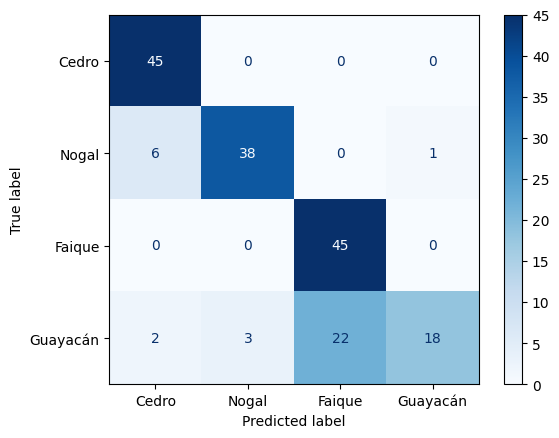

********** Modelo guardado en Modelos/Modelo_E12__CON_aumento_con_tri.pt **********


In [ ]:
# test_model(model_ft, test_loader, df_test, file_name_model=f"Modelo_{n_experimento}_{consideraciones}")
test_model(model, test_loader, df_test, file_name_model=f"Modelo_{n_experimento}_{consideraciones}")

In [ ]:
df_test

,F1-score,Recall,Accuracy,Precision,Batch Size,Learning Rate
0,0.79204,0.811111,0.811111,0.848724,32,0.001


# 7. Registros

## 7.1 Descarga y registro de las métricas

In [ ]:
df_entrenamiento.to_csv(os.path.join(path_save,"Train_" + n_experimento + consideraciones + ".csv"),  index=False, encoding='utf-8')

In [ ]:
#df_test.to_csv("Registros/Registros_test_E7_sintri_rgb_sin_aumento.csv",  index=False, encoding='utf-8')
df_test.to_csv(os.path.join(path_save,"Test_" + n_experimento + consideraciones + ".csv"),  index=False, encoding='utf-8')

# 8. Métricas

Evaluación del modelo con atencion y aumento de datos

In [50]:
device = torch.device("cpu")

model_tri = WoodClassifierWithTriAttention(
    num_classes=4,
    use_tri_attention=False
)

state_dict = torch.load(
    "Modelo_E12__CON_aumento_sin_tri.pt",
    map_location=torch.device("cpu")
)

model_tri.load_state_dict(state_dict)
model_tri.to(device)
model_tri.eval()

WoodClassifierWithTriAttention(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0):

In [ ]:
from sklearn.metrics import precision_score
running_corrects = 0

all_labels = []
all_preds = []
# Se desactiva la gradiante. Puesto que es Test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

         # Forward pass
        # Ejecución del modelo y predicciones
        outputs = model_tri(inputs)
        _, preds = torch.max(outputs, 1)

        # Acumular todos los labels y predicciones
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("F1-score (macro):", f1)

INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original


INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las tran

Accuracy: 0.8166666666666667
Precision (macro): 0.8418016194331983
F1-score (macro): 0.8183304647160068


## 8.1 Acc1

In [ ]:
correct = 0
total = 0
model_tri.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tri(inputs)
        _, preds = outputs.topk(1, 1, True, True)
        correct += (preds.squeeze() == labels).sum().item()
        total += labels.size(0)

acc1 = correct / total
print("Top-1 Accuracy:", acc1)

INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las tran

Top-1 Accuracy: 0.8166666666666667


## 8.2 Acc 5

In [ ]:
correct = 0
total = 0
model_tri.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tri(inputs)
        _, preds = outputs.topk(3, 1, True, True)
        preds = preds.t()
        correct += (preds == labels.view(1, -1)).sum().item()
        total += labels.size(0)

acc5 = correct / total
print("Top-5 Accuracy:", acc5)

INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las transformaciones <Normales>
INFO - SIN mecanismo de atención. Clasificador original
INFO - Se aplicaron las tran

Top-5 Accuracy: 1.0


## Num params

In [ ]:
total_params = sum(p.numel() for p in model_tri.parameters())
print("Número de parámetros:", total_params)

Número de parámetros: 4207156


In [ ]:
trainable_params = sum(p.numel() for p in model_tri.parameters() if p.requires_grad)
print("Número de parámetros entrenables:", trainable_params)

Número de parámetros entrenables: 4207156


## GFLOPS

In [ ]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model_tri, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
print("FLOPs:", macs)

INFO - SIN mecanismo de atención. Clasificador original


FLOPs: 455.84 MMac


## File size

In [ ]:
import os
file_path = "Modelo_E12__CON_aumento_sin_tri.pt"
size_MB = os.path.getsize(file_path) / (1024 * 1024)
print("Tamaño del archivo:", size_MB, "MB")

Tamaño del archivo: 16.30282497406006 MB


## Time

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity


# Obtén un batch del dataloader
batch = next(iter(test_loader))

# Si tu DataLoader devuelve (inputs, labels)
if isinstance(batch, (list, tuple)) and len(batch) == 2:
    dummy_input, _ = batch
else:
    dummy_input = batch  # por si devuelve solo un tensor

# Mover a GPU si es necesario
if torch.cuda.is_available():
    dummy_input = dummy_input.cuda()

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True
) as prof:
    with record_function("model_inference"):
        model_tri(dummy_input)   # ← SOLO pasar el tensor, NO una lista

print(prof.key_averages().table(sort_by="cpu_time_total"))

INFO - Se aplicaron las transformaciones <Normales>
/home/daniel/Documentos/Universidad/Revista/Evidencias/modelo-clasificacion-especies-maderables/Base code/.venv/lib/python3.13/site-packages/torch/autograd/profiler.py:267: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
INFO - SIN mecanismo de atención. Clasificador original
ERROR:2026-01-20 21:27:05 6160:6160 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        18.95%      14.704ms       100.00%      77.589ms      77.589ms             1  
                    aten::conv2d         1.64%       1.269ms        53.78%      41.730ms     673.067us            62  
               aten::convolution         2.71%       2.103ms        52.15%      40.461ms     652.593us            62  
              aten::_convolution         3.28%       2.543ms        49.44%      38.357ms     618.669us            62  
        aten::mkldnn_convolution        38.60%      29.952ms        40.22%      31.210ms     800.244us            39  
                aten::batch_norm         0.58%  

## T-SNE

In [51]:

class MobileNetV3FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        # Tomamos todo el classifier excepto la última capa (que produce las 4 clases)
        self.feature_layer = nn.Sequential(*list(self.model.backbone.classifier.children())[:-1])

    def forward(self, x):
        # Paso por el backbone hasta avgpool
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)  # aplanamos a (batch_size, 960)
        # Paso por el classifier hasta la penúltima capa
        x = self.feature_layer(x)  # ahora x tiene forma (batch_size, 1280)
        return x

In [52]:
# Supongamos que `model` es tu MobileNetV3 entrenado
extractor = MobileNetV3FeatureExtractor(model_tri)
extractor.eval()

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # si usas GPU
        features = extractor(images)  # (batch_size, 1280)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenamos todos los batches
all_features = torch.cat(all_features, dim=0)  # (num_samples, 1280)
all_labels = torch.cat(all_labels, dim=0)      # (num_samples,)


In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

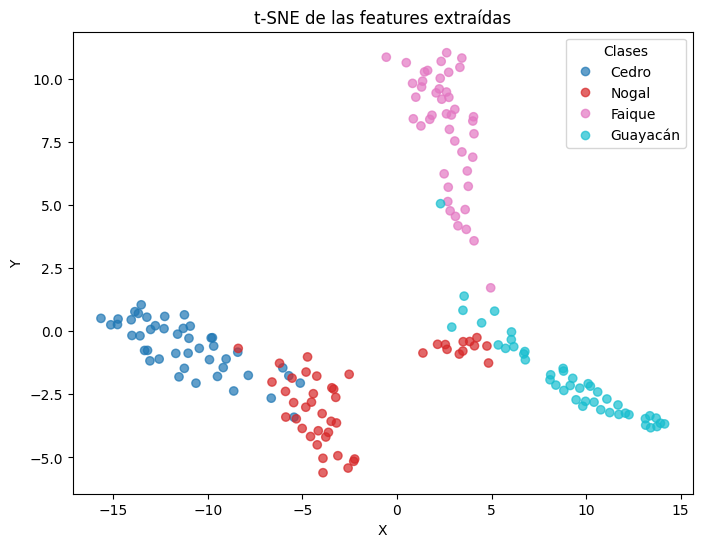

In [54]:
classes = {0:'Cedro', 1:'Nogal', 2:'Faique', 3:'Guayacán'}

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=all_labels.numpy(),
    cmap='tab10',
    alpha=0.7
)

# Leyendas
handles, _ = scatter.legend_elements()
plt.legend(handles, [classes[i] for i in range(len(classes))], title="Clases")

plt.savefig("TSNE_aumento_atencion.png", dpi=300)
plt.title("t-SNE de las features extraídas")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Grad CAM - Mapa de calor

In [55]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hooks seguros (backward-hook deprecated → usar register_full_backward_hook)
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self):
        grads = self.gradients
        activations = self.activations

        # GAP en gradientes → pesos por canal
        weights = grads.mean(dim=(2, 3), keepdim=True)

        # CAM
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        # Normalizar y convertir a imagen
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


def apply_gradcam(model, img_tensor, device, target_layer):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)

    gradcam = GradCAM(model, target_layer)

    # Forward
    output = model(img_tensor)
    class_idx = output.argmax().item()

    # Backward
    model.zero_grad()
    output[0, class_idx].backward()

    cam = gradcam.generate_heatmap()

    # Imagen original
    img = img_tensor[0].permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Heatmap
    heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    # Superposición
    superimposed = 0.4 * heatmap + 0.6 * img
    superimposed = np.clip(superimposed, 0, 1)

    return img, heatmap, superimposed


Cedro


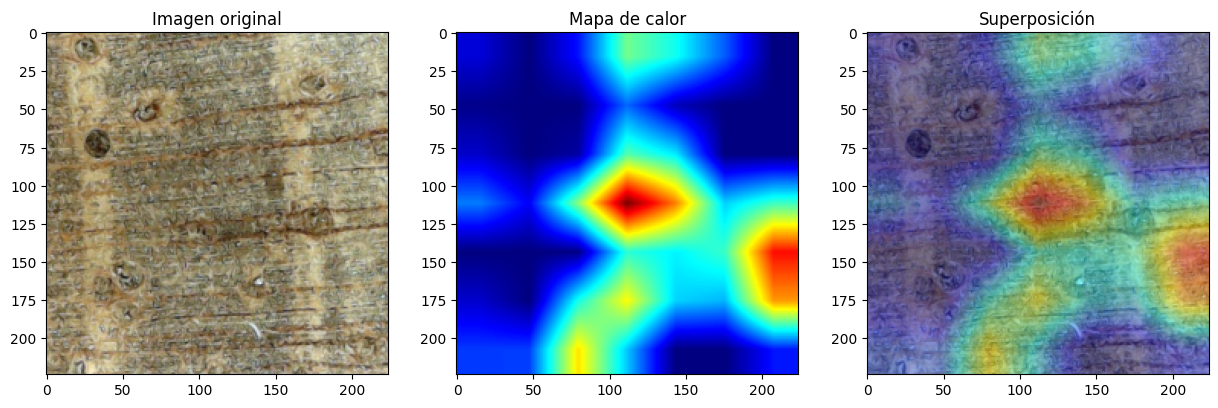

In [56]:
dataset = test_loader.dataset

idx = 75  # imagen número 123 del dataset completo
img_tensor, label = dataset[idx]
print(classes[label])

target_layer = model_tri.backbone.features[16][0]

img, heat, superimposed = apply_gradcam(model_tri, img_tensor, device, target_layer)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Imagen original")
plt.subplot(1, 3, 2); plt.imshow(heat); plt.title("Mapa de calor")
plt.subplot(1, 3, 3); plt.imshow(superimposed); plt.title("Superposición")
plt.savefig("GRAD_CAM_Cedro.png", dpi=300) # Guardar imágen
plt.show()